In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyqubo import Array
import neal
from dwave.system import LeapHybridSampler
from dwave.system import DWaveSampler

In [4]:
data = pd.read_csv('datasets/linear_regression_data.csv')
data = data.rename(columns={"deneyim": "x", "maas": "y"})

In [5]:
X = data['x']
Y = np.array(data['y']*0.1)

X = np.c_[np.ones(X.shape[0]), X] 

In [6]:
print(X)

[[ 1.   0.5]
 [ 1.   0. ]
 [ 1.   1. ]
 [ 1.   5. ]
 [ 1.   8. ]
 [ 1.   4. ]
 [ 1.  15. ]
 [ 1.   7. ]
 [ 1.   3. ]
 [ 1.   2. ]
 [ 1.  12. ]
 [ 1.  10. ]
 [ 1.  14. ]
 [ 1.   6. ]]


In [7]:
k = 30

# Percision vector
P = np.array([])
for i in range(k//2):
    p = np.array([2**(i-1),-2**(i-1)])
    P = np.append(P,p)
P = np.sort(P)

# Percision matrix
M = np.kron(np.identity(2), P)

# weight vector
w = Array.create('w', shape=2*k, vartype='BINARY')

A = w.T@M.T@X.T@X@M@w
b = -2*w.T@M.T@X.T@Y

# Hamiltonian
H = A + b

In [8]:
# to compute the weight an bias
def get_beta(w_sample, k, M):
    
    weight_list = []
    for i in range(2*k):
        weight_list.append(f'w[{i}]')
    #print(weight_list)
    w_array = np.array([])
    for weight in weight_list:
        placeholder = np.array([w_sample[weight]])
        w_array = np.append(w_array, placeholder)

    print(w_array)

    beta_ = M@w_array
    return beta_

In [9]:
model = H.compile()
bqm = model.to_bqm()

In [10]:
sampler = neal.SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=100)
decoded_samples = model.decode_sampleset(sampleset)
best_sample = min(decoded_samples, key=lambda x: x.energy)

cbeta = get_beta(best_sample.sample, k, M)
print(cbeta)

[0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1.
 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1.
 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1.]
[165.5 114. ]


In [100]:
sampler = LeapHybridSampler()
sampleset = sampler.sample(bqm)

decoded_samples = model.decode_sampleset(sampleset)
best_sample = min(decoded_samples, key=lambda x: x.energy)

qbeta = get_beta(best_sample.sample, k, M)
print(qbeta)

[1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0.
 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
[168.5 113.5]


In [101]:
#import dwave.inspector
#dwave.inspector.show(sampleset)

In [11]:
def get_error(beta):
    error = 0
    for idx,i in enumerate(X[:,1]):
        error += abs(beta[0]+beta[1]*i - Y[idx])
    error *= 1/Y.size
    return error

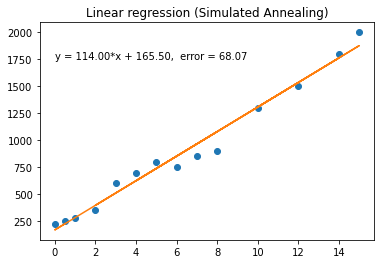

In [12]:
plt.plot(X[:,1], Y, 'o')
plt.plot(X[:,1], cbeta[0]+cbeta[1]*X[:,1])
plt.text(0,1750,'y = {:.2f}*x + {:.2f},  error = {:.2f}'.format(cbeta[1], cbeta[0], get_error(cbeta)))
plt.title('Linear regression (Simulated Annealing)')
plt.show()

NameError: name 'qbeta' is not defined

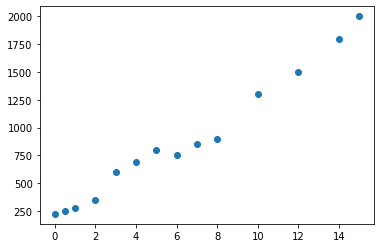

In [13]:
plt.plot(X[:,1], Y, 'o')
plt.plot(X[:,1], qbeta[0]+qbeta[1]*X[:,1])
plt.text(0,1750,'y = {:.2f}*x + {:.2f},  error = {:.2f}'.format(qbeta[1], qbeta[0], get_error(qbeta)))
plt.title('Linear regression (Quantum Annealing)')
plt.show()